In [ ]:
!pip install scikit-image


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
from skimage.io import imread, imshow
from skimage import color, feature

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import seaborn as sns


# For ML Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import sklearn.metrics as metrics
from tensorflow.keras import regularizers
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

2023-11-21 06:09:00.500799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 06:09:00.633102: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-21 06:09:00.633129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-21 06:09:00.650383: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 06:09:01.663735: W tensorflow/stream_executor/platform/de

In [ ]:
#Paths to data directories
caution_dir = './caution'
danger_dir = './danger'

#Pull in training data
caution_data = []
caution_data_labels = []

danger_data = []
danger_lake_labels = []


#getting the paths and labels of our caution data
for image in os.listdir(caution_dir):
    caution_data.append(caution_dir+'/'+image)
    caution_data_labels.append('caution')

#getting the paths and labels of our danger data
for image in os.listdir(danger_dir):
        danger_data.append(danger_dir+'/'+image)
        danger_lake_labels.append('danger')

# Now you can shuffle your data
caution_data, caution_data_labels = shuffle(caution_data, caution_data_labels)
danger_data, danger_lake_labels = shuffle(danger_data, danger_lake_labels)

In [ ]:
df_caution = pd.DataFrame({'image_path': caution_data, 'label': caution_data_labels})
df_caution

,image_path,label
0,./caution/155_image5-20200729-121538.jpg,caution
1,./caution/BloomImg1-20230822-124307.jpg,caution
2,./caution/L1j.png,caution
3,./caution/5AJ9UNGp0Wp0Z2ihUiUDm7UCIgC8TUmlDcTT...,caution
4,./caution/BloomImg1-20230523-094318.jpg,caution
...,...,...
117,./caution/5AJ9UNGr5OlAWryl_r-ppwhJ5ayi6x5k8SAQ...,caution
118,./caution/BloomImg1-20220616-165046.JPG,caution
119,./caution/186_image2-20200817-152444.jpg,caution
120,./caution/122_image1-20200707-151253.jpg,caution


In [ ]:
df_danger = pd.DataFrame({'image_path': danger_data, 'label': danger_lake_labels})
df_danger

,image_path,label
0,./danger/5ACD99~1.PNG,danger
1,./danger/5AB82B~1.PNG,danger
2,./danger/5AJ9UN~1.PNG,danger
3,./danger/5A0451~1.PNG,danger
4,./danger/5A7B40~1.PNG,danger
...,...,...
143,./danger/L46.png,danger
144,./danger/2019-0912_DSCN1486_Flaming_Gorge_Adja...,danger
145,./danger/L4b.png,danger
146,./danger/L44.png,danger


In [ ]:
df = pd.concat([df_caution, df_danger], axis = 0)
df

,image_path,label
0,./caution/155_image5-20200729-121538.jpg,caution
1,./caution/BloomImg1-20230822-124307.jpg,caution
2,./caution/L1j.png,caution
3,./caution/5AJ9UNGp0Wp0Z2ihUiUDm7UCIgC8TUmlDcTT...,caution
4,./caution/BloomImg1-20230523-094318.jpg,caution
...,...,...
143,./danger/L46.png,danger
144,./danger/2019-0912_DSCN1486_Flaming_Gorge_Adja...,danger
145,./danger/L4b.png,danger
146,./danger/L44.png,danger


In [ ]:
df['binary_label'] = df['label'].map({'caution': 0, 'danger': 1})
df

,image_path,label,binary_label
0,./caution/155_image5-20200729-121538.jpg,caution,0
1,./caution/BloomImg1-20230822-124307.jpg,caution,0
2,./caution/L1j.png,caution,0
3,./caution/5AJ9UNGp0Wp0Z2ihUiUDm7UCIgC8TUmlDcTT...,caution,0
4,./caution/BloomImg1-20230523-094318.jpg,caution,0
...,...,...,...
143,./danger/L46.png,danger,1
144,./danger/2019-0912_DSCN1486_Flaming_Gorge_Adja...,danger,1
145,./danger/L4b.png,danger,1
146,./danger/L44.png,danger,1


In [ ]:
import numpy

# Define the target size for resizing
target_size = (224, 224)

# Function to load and resize images
def load_and_resize_image(file_path):
    img = imread(file_path)
    img_resize = tf.image.resize(img, size=(224, 224))  # Resize the image to the target size
    image_np = img_resize.numpy().astype(np.uint8)
    return image_np

# Apply the function to each row in the DataFrame
df['resized_image'] = df['image_path'].apply(load_and_resize_image)

2023-11-21 06:12:24.188500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-21 06:12:24.188534: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-21 06:12:24.188553: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-2359b23e-ba82-4f61-a568-68ab2a2d2f2a): /proc/driver/nvidia/version does not exist
2023-11-21 06:12:24.188807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
positive_images = []
negative_images = []

for index, row in df.iterrows():
    if 'caution' in row['image_path']:
        negative_images.append(row['resized_image'])
    else:
        positive_images.append(row['resized_image'])

In [ ]:
print(len(positive_images))
print(len(negative_images))

148
122


In [ ]:
# from sklearn.preprocessing import StandardScaler

# def compute_lbp_features(images):
#     lbp_features = []
#     scaler = StandardScaler()
    
#     for image in images:
#         # Standardize each color channel independently
#         image = image.astype(np.uint8)
#         standardized_image = np.zeros_like(image, dtype=np.float64)
#         for channel in range(image.shape[-1]):
#             standardized_image[:, :, channel] = scaler.fit_transform(image[:, :, channel])

#         # Compute LBP features for each channel
#         radius = 3
#         n_points = 24 * radius
#         lbp_red = feature.local_binary_pattern(standardized_image[:, :, 0], n_points, radius, method='uniform')
#         lbp_green = feature.local_binary_pattern(standardized_image[:, :, 1], n_points, radius, method='uniform')
#         lbp_blue = feature.local_binary_pattern(standardized_image[:, :, 2], n_points, radius, method='uniform')

#         # Combine LBP features from all channels
#         lbp_combined = np.hstack((lbp_red.flatten(), lbp_green.flatten(), lbp_blue.flatten()))
#         lbp_features.append(lbp_combined)

#     return np.array(lbp_features)

# positive_lbp_features = compute_lbp_features(positive_images[:189])
# negative_lbp_features = compute_lbp_features(negative_images[:189])

In [ ]:
import numpy as np
from skimage import color, feature, img_as_ubyte
from sklearn.preprocessing import StandardScaler

def compute_lbp_features(images):
    lbp_features = []

    for image in images:
        # Convert image to integer data type (uint8) to address the warning
        image_uint8 = img_as_ubyte(image)

        # Standardize each color channel independently
        scaler = StandardScaler()
        standardized_image = np.zeros_like(image_uint8, dtype=np.float64)
        for channel in range(image_uint8.shape[-1]):
            standardized_image[:, :, channel] = scaler.fit_transform(image_uint8[:, :, channel])

        # Compute LBP features for each channel
        radius = 3
        n_points = 24 * radius
        lbp_red = feature.local_binary_pattern(standardized_image[:, :, 0], n_points, radius, method='uniform')
        lbp_green = feature.local_binary_pattern(standardized_image[:, :, 1], n_points, radius, method='uniform')
        lbp_blue = feature.local_binary_pattern(standardized_image[:, :, 2], n_points, radius, method='uniform')

        # Combine LBP features from all channels
        lbp_combined = np.hstack((lbp_red.flatten(), lbp_green.flatten(), lbp_blue.flatten()))
        lbp_features.append(lbp_combined)

    return np.array(lbp_features)

In [ ]:
positive_lbp_features = compute_lbp_features(positive_images[:122])
negative_lbp_features = compute_lbp_features(negative_images[:122])

/root/venv/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/root/venv/lib/python3.9/

In [ ]:
positive_labels = np.ones(len(positive_images[:122]))
negative_labels = np.zeros(len(negative_images[:122]))

In [ ]:
all_features = np.concatenate([positive_lbp_features, negative_lbp_features], axis=0)
all_labels = np.concatenate([positive_labels, negative_labels])

In [ ]:
# Apply t-SNE
from sklearn.manifold import TSNE

# Assuming len(all_features) is the number of samples in your dataset
perplexity = min(30, len(all_features) - 1)

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
embedded_features = tsne.fit_transform(all_features)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


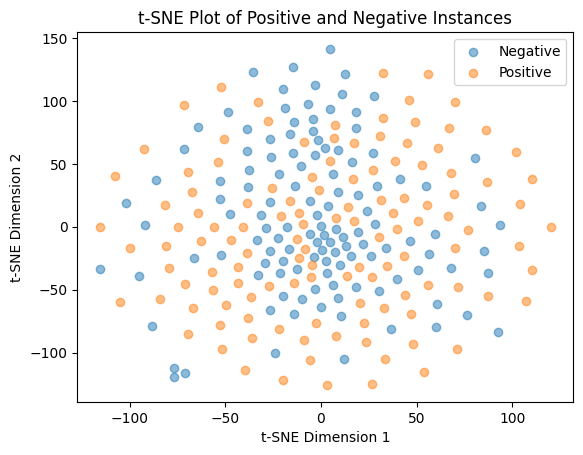

In [ ]:
# Visualize t-SNE
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Negative', alpha=0.5)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Positive', alpha=0.5)

plt.title('t-SNE Plot of Positive and Negative Instances')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


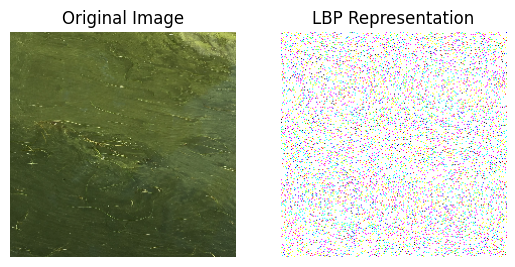

In [ ]:
# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(positive_images[1])
plt.title('Original Image')
plt.axis('off')

# Plot LBP representation
plt.subplot(1, 2, 2)
# Adjust the shape based on the length of the flattened LBP feature vector
reshape_size = (positive_images[1].shape[0], positive_images[1].shape[1], -1)
plt.imshow(np.reshape(positive_lbp_features[1], reshape_size), cmap='gray')
plt.title('LBP Representation')
plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


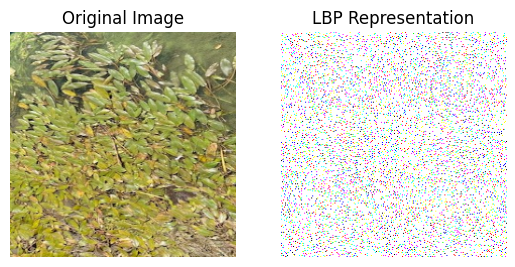

In [ ]:
# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(positive_images[2])
plt.title('Original Image')
plt.axis('off')

# Plot LBP representation
plt.subplot(1, 2, 2)
# Adjust the shape based on the length of the flattened LBP feature vector
reshape_size = (positive_images[2].shape[0], positive_images[2].shape[1], -1)
plt.imshow(np.reshape(positive_lbp_features[2], reshape_size), cmap='gray')
plt.title('LBP Representation')
plt.axis('off')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2359b23e-ba82-4f61-a568-68ab2a2d2f2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>